## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as utils
import numpy as np
import matplotlib.pyplot as plt
from imbalancer import Imbalancer
from torch.utils.data import Subset

## Generator

In [12]:
class Generator(nn.Module):
    def __init__(self,input_dim, out_dim):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, out_dim),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.gen(x) 

## Discriminator

In [13]:
class Discriminator(nn.Module):
    def __init__(self,input_dim):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
             nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        return self.disc(x)

## Hyperparameter

In [14]:
image_size = 1024
noise_dim = 100
batch_size = 64
alpha = 0.0003
epochs = 500
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load & Imbalance The Dataset (2 approaches)

In [15]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [ ]:
dataset = torchvision.datasets.FashionMNIST(root="./", train=True, download=True, transform=transform)
images = np.stack([np.array(img) for img, _ in dataset])
labels = [label for _, label in dataset]
minor_class = 1
imb = Imbalancer(images, labels, minor_class=minor_class, keep_ratio=0.2, output_path="../imbalanced_dataset_vanilla_fashion_mnist")
imb.imbalance()
imb.visualize()
imb.save()

data = torch.load("../imbalanced_dataset_vanilla_fashion_mnist/data.pt") # Produced by imbalancer.py
labels = torch.load("../imbalanced_dataset_vanilla_fashion_mnist/labels.pt") # Produced by imbalancer.py
mask = labels == 1
filtered_data = data[mask]
filtered_labels = labels[mask]

#====================================================================================
# Loading locally

# dataset = torchvision.datasets.FashionMNIST(root="./", train=True, download=True, transform=transform)
# images = np.stack([np.array(img) for img, _ in dataset])
# labels = [label for _, label in dataset]
# targets = np.array(dataset.targets)
# class_counts = {i: 5000 for i in range(10)}
# class_counts[1] = 500  # Make class 1 smaller

# indices = []
# for cls, count in class_counts.items():
#     cls_indices = np.where(targets == cls)[0]
#     indices.extend(cls_indices[:count])
# imbalanced_subset = Subset(dataset, indices)

# images = []
# labels = []
# for img, label in imbalanced_subset:
#     images.append(img)
#     labels.append(label)
# images = torch.stack(images)
# labels = torch.tensor(labels)

# images = []
# labels = []

# for img, label in imbalanced_subset:
#     images.append(img)
#     labels.append(label)

# images = torch.stack(images)
# labels = torch.tensor(labels)
# mask_0 = labels == 1


# images_1 = images[mask_0]
# labels_1 = labels[mask_0]
# dataset_1 = TensorDataset(images_1, labels_1)
# len(dataset_1)

In [ ]:
dataset = TensorDataset(filtered_data, filtered_labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Create Generator & Discriminator

In [18]:
gen = Generator(noise_dim, image_size).to(device)
gen_optim = optim.Adam(gen.parameters(), lr=alpha)
disc = Discriminator(image_size).to(device)
disc_optim = optim.Adam(disc.parameters(), lr=alpha)
criterion = nn.BCELoss()

In [19]:
def show_generated_images(generator, noise_dim, device, epoch, save=False):
    generator.eval()

    with torch.no_grad():
        fixed_noise = torch.randn(64, noise_dim).to(device)
        fake_images = generator(fixed_noise).reshape(-1, 1, 32, 32)

    grid = utils.make_grid(fake_images, nrow=8, normalize=True)

    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(f"Generated Images - Epoch {epoch + 1}")
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())

    if save:
        plt.savefig(f"generated_epoch_{epoch + 1}.png")
    plt.show()

    generator.train()


## Training

In [ ]:
for e in range(epochs):
    for batch_index, (real_images, _) in enumerate(dataloader):
        real_images = real_images.float().reshape(-1, image_size).to(device)
        batch_size = real_images.shape[0]

        noise_vector = torch.randn(batch_size, noise_dim).to(device)
        fake_images = gen(noise_vector)

        # === Label Smoothing ===
        real_labels = torch.full((batch_size, 1), 0.9,dtype=torch.float32, device=device)
        fake_labels = torch.zeros((batch_size, 1), device=device)

        # === Train Discriminator ===
        disc_fake_predictions = disc(fake_images.detach())
        disc_real_predictions = disc(real_images)

        disc_loss = (
            criterion(disc_fake_predictions, fake_labels) + \
            criterion(disc_real_predictions, real_labels)
        ) / 2

        disc_optim.zero_grad()
        disc_loss.backward()
        disc_optim.step()

        # === Train Generator ===
        predictions = disc(fake_images)
        gen_loss = criterion(predictions, real_labels)

        gen_optim.zero_grad()
        gen_loss.backward()
        gen_optim.step()

    print(f"Epoch {e+1}/{epochs} | D Loss: {disc_loss.item():.4f} | G Loss: {gen_loss.item():.4f}")
    if (e+1) % 10 == 0:
        show_generated_images(gen, noise_dim, device, e)


## Show Samples of The Generated Images

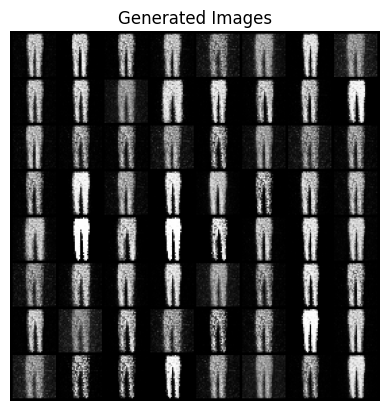

In [ ]:
with torch.no_grad():
    noise = torch.randn(64, noise_dim).to(device)
    fake_images = gen(noise).view(-1, 1, 32, 32) * 0.5 + 0.5
    grid = torchvision.utils.make_grid(fake_images, nrow=8)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title("Generated Images")
    plt.axis("off")
    plt.show()

## Save The Model

In [22]:
import os

save_dir = "../saved_models"
os.makedirs(save_dir, exist_ok=True)
torch.save(gen.state_dict(), os.path.join(save_dir, f"vanilla_generator_fashion_mnist_epoch_{epochs}.pth"))
torch.save(disc.state_dict(), os.path.join(save_dir, f"vanilla_discriminator_fashion_mnist_epoch_{epochs}.pth"))

## Balancing The Dataset for Representation

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
import os

gen_path = f"../saved_models/vanilla_generator_fashion_mnist_epoch_{epochs}.pth"
imbalanced_data_path = "../imbalanced_dataset_vanilla_fashion_mnist/data.pt"
imbalanced_labels_path = "../imbalanced_dataset_vanilla_fashion_mnist/labels.pt"
output_balanced_dir = "../balanced_dataset_vanilla_fashion_mnist"

os.makedirs(output_balanced_dir, exist_ok=True)

minor_class = 1

data = torch.load(imbalanced_data_path)
labels = torch.load(imbalanced_labels_path)

if data.dim() == 3:
    data = data.unsqueeze(1)


class_counts = torch.bincount(labels)
max_count = class_counts.max().item()
minor_count = class_counts[minor_class].item()
num_to_generate = max_count - minor_count
print(f"Need to generate {num_to_generate} samples for class {minor_class}.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gen = Generator(noise_dim, image_size).to(device)
gen.load_state_dict(torch.load(gen_path, map_location=device))
gen.eval()

generated_images = []

with torch.no_grad():
    for _ in range((num_to_generate + batch_size - 1) // batch_size):
        current_batch_size = min(batch_size, num_to_generate - len(generated_images))
        noise = torch.randn(current_batch_size, noise_dim).to(device)
        fake_imgs = gen(noise)
        fake_imgs = fake_imgs.view(current_batch_size, 1, 32, 32)
        # fake_imgs = torch.nn.functional.interpolate(fake_imgs, size=(28, 28), mode='bilinear', align_corners=False)
        fake_imgs = fake_imgs.cpu()
        generated_images.append(fake_imgs)

generated_images = torch.cat(generated_images, dim=0)
generated_labels = torch.full((generated_images.size(0),), minor_class, dtype=torch.long)

balanced_data = torch.cat((data, generated_images), dim=0)
balanced_labels = torch.cat((labels, generated_labels), dim=0)

torch.save(balanced_data, os.path.join(output_balanced_dir, "data.pt"))
torch.save(balanced_labels, os.path.join(output_balanced_dir, "labels.pt"))

print(f"Balanced dataset saved to: {output_balanced_dir}")

Need to generate 4800 samples for class 1.
Balanced dataset saved to: ../balanced_dataset_vanilla_fashion_mnist


## Classes Distribution Before & After

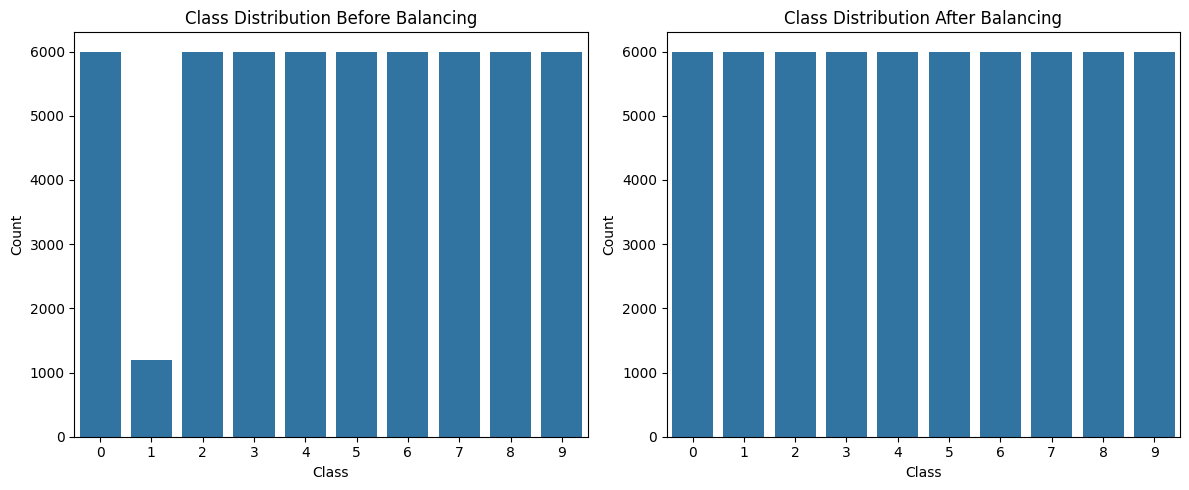

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Before balancing
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=labels.numpy())
plt.title('Class Distribution Before Balancing')
plt.xlabel('Class')
plt.ylabel('Count')

# After balancing
plt.subplot(1, 2, 2)
sns.countplot(x=balanced_labels.numpy())
plt.title('Class Distribution After Balancing')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()